In [1]:
import mysql.connector
import tensorflow as tf
import keras
import numpy as np
from datetime import datetime

import cv2
from PIL import Image
import matplotlib.pyplot as plt
from mtcnn.mtcnn import MTCNN

In [2]:
class Database:

    def __init__(self, hostname, username, password, database=None):

        self.host = hostname
        self.user = username
        self.password = password
        self.database = database


    def connect_db(self):
        mydb = mysql.connector.connect( host = self.host,
                                        user = self.user,
                                        passwd = self.password,
                                        database = self.database
                                        )
        return mydb

    

    def create_db(self, name):
        connection = Database.connect_db(self)
        cursor = connection.cursor()
        
        cursor.execute(f"CREATE DATABASE {name}")
        print('Database Created successfully')

    def create_table(self, name, features, database):

        self.database = database
        connection = Database.connect_db(self)
        cursor = connection.cursor()
        cursor.execute(f"CREATE TABLE {name} {features}")
        print('Table created succeccfully')

In [34]:
class worker():

    def __init__(self, new_connection, cursor, model):
        #super().__init__(model)
        
        self.new_connection = new_connection
        self.cursor = cursor

        self.img = self.image(model)


    class image:
     
        def __init__(self, model):
            self.model = model


        def img_to_encoding(self, img):
            img = cv2.resize(img, (160, 160))
            img = np.around(np.array(img) / 255.0, decimals=12)
            x_train = np.expand_dims(img, axis=0)
            embedding = self.model.predict_on_batch(x_train)
            return embedding / np.linalg.norm(embedding, ord=2)

        def directory_img_encoding(self,image_path):
            img = tf.keras.preprocessing.image.load_img(image_path, target_size=(160, 160))
            img = np.around(np.array(img) / 255.0, decimals=12)
            x_train = np.expand_dims(img, axis=0)
            embedding = self.model.predict_on_batch(x_train)
            return embedding / np.linalg.norm(embedding, ord=2)

        
        def capture(self):
            vid = cv2.VideoCapture(0)
            
            while(True):
            
                ret, frame = vid.read()
                cv2.imshow('frame', frame)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
            vid.release()
            cv2.destroyAllWindows()
            return frame

        def extract(self, frame):
            
            detector = MTCNN()
            results = detector.detect_faces(frame)
            x1, y1, width, height = results[0]['box']
            # bug fix
            x1, y1 = abs(x1), abs(y1)
            x2, y2 = x1 + width, y1 + height
            # extract the face
            face = frame[y1:y2, x1:x2]
            # resize pixels to the model size
            image = Image.fromarray(face)
            image = image.resize((160,160))
            return image



    def register_worker(self):

        id = int(input('Enter a new id: '))
        name = str(input('Enter your name: '))
        gender = input('What is your gender: ')
        address = input('Enter you address: ')
        position = input('What is your position in the company')
        employment_date = input("Enter your employment date: ")
        resumption_date = input("Enter your resumption date: ")
        salary_per_hr = input('Enter worker hourly pay: ')
        daily_work_hrs = input('Enter work total work hours per day: ')

        record = (id, name, gender, address, position, employment_date,
                        resumption_date, salary_per_hr, daily_work_hrs)
        self.cursor.execute(f"insert into workers_info\
                        values{record}")
        self.new_connection.commit()
        print("Successully added the worker's record")

    def sign_in(self, img_database):
    
        id = int(input('Enter your id: '))
        validation = self.worker_val('workers_info', id)

        if validation =='pass':
            date = datetime.today().strftime('%Y-%m-%d')
             #str(input('Enter your name: '))
            self.cursor.execute(f"select name from workers_info\
                                        where id = {id}")
            name = self.cursor.fetchone()[0]
            

            frame = self.img.capture()
            #img = extract(frame)
            img = np.asarray(frame)
            plt.imshow(img)
            real_worker = self.verify(img, name, img_database)

            if real_worker == True:
            
                time_in =  datetime.today().strftime('%H:%M')
                time_out = datetime.today().strftime('%H:%M')

                record = (id, date, name, time_in, time_out)
                self.cursor.execute(f"insert into register \
                            values{record}")

                self.new_connection.commit()
                print("Successully added the new record")

            else:
                print('Individual recod not in database')


    

    def worker_val(self, dbname, id):

        self.cursor.execute(f"select * from {dbname}")
        myresult = self.cursor.fetchall()
        workers_id = [x[0] for x in myresult]
        if id in workers_id:
            return ('pass')
        else:
            reg = input('Will the worker be registered: ')
            reg = reg.lower()

            if reg=='yes':
                new_input = self.register_worker()
            else:
                print('Individual not in company database')

    def signin_val(self, dbname, id):

        date = datetime.today().strftime('%Y-%m-%d')
        self.cursor.execute(f"select * from {dbname} where date = '{date}'")
        myresult = self.cursor.fetchall()
        workers_id = [x[0] for x in myresult]

        if id in workers_id:
            return ('pass')
        
        else:
            print('Individual did not sign in today')

    def sign_out(self, img_database):

        id = int(input('Enter your id: '))
        clock_out = self.signin_val('register', id)

        if clock_out=='pass':

            #name = str(input('Enter your name: '))
            self.cursor.execute(f"select name from register\
                                        where id = {id}")

            name = self.cursor.fetchone()[0]
            frame = self.img.capture()
            #img = extract(frame)
            img = np.asarray(frame)
            plt.imshow(img)
            real_worker = self.verify(img, name, img_database)

            if real_worker == True:
                    
                time = datetime.now().strftime('%H:%M')
                query = f"update register set \
                            time_out = '{time}' \
                            where id = {id}"
                self.cursor.execute(query)
                self.new_connection.commit()
                print("Successully updated the record")


    def verify(self, img, identity, database):

        encoding = self.img.img_to_encoding(img)
        dist = np.linalg.norm(database[identity] -  encoding)
        if dist < 0.7:
            return True
        else:
            return False

In [4]:
host_name = 'localhost'
user_name = 'root'
password = 'Pattern'
database_name =  'GraceTouch'

db = Database(host_name, user_name, password)
db.create_db(database_name)



workers_info = "(id int not null, name varchar(50), gender char(1), address varchar(30),\
                position varchar(10), employment_date date, resumption_date date,\
                salary_per_hr float, daily_work_hrs int, primary key (id))"
db.create_table(name = 'workers_info', features = workers_info, database = 'gracetouch')


company_register = "(id int not null, date date, name varchar(50), \
                     time_in time, time_out time, primary key (id))"
db.create_table(name = 'register', features = company_register, database = 'gracetouch')

new_connection = db.connect_db()
cursor = new_connection.cursor(buffered=True)

Database Created successfully
Table created succeccfully
Table created succeccfully


In [36]:
frmodel = keras.models.load_model('./converted.h5')
woker_cls = worker(new_connection,cursor,frmodel)

In [7]:
woker_cls.register_worker()

Successully added the worker's record


In [19]:
def directory_img_encoding(image_path, model = frmodel):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(160, 160))
    img = np.around(np.array(img) / 255.0, decimals=12)
    x_train = np.expand_dims(img, axis=0)
    embedding = model.predict_on_batch(x_train)
    return embedding / np.linalg.norm(embedding, ord=2)

In [20]:
database = {}
database["danielle"] = directory_img_encoding("images/danielle.png")
database["younes"] = directory_img_encoding("images/younes.jpg")
database["tian"] =  directory_img_encoding("images/tian.jpg")
database["andrew"] =  directory_img_encoding("images/andrew.jpg")
database["kian"] = directory_img_encoding("images/kian.jpg")
database["dan"] =  directory_img_encoding("images/dan.jpg")
database["sebastiano"] =  directory_img_encoding("images/sebastiano.jpg")
database["bertrand"] =  directory_img_encoding("images/bertrand.jpg")
database["kevin"] =  directory_img_encoding("images/kevin.jpg")
database["felix"] =  directory_img_encoding("images/felix.jpg")
database["benoit"] =  directory_img_encoding("images/benoit.jpg")
database["arnaud"] =  directory_img_encoding("images/arnaud.jpg")



database["godwin"] = directory_img_encoding("C:/Users/Godwin/Pictures/ManyCam/My Snapshot_1.jpg")

Successully updated the record


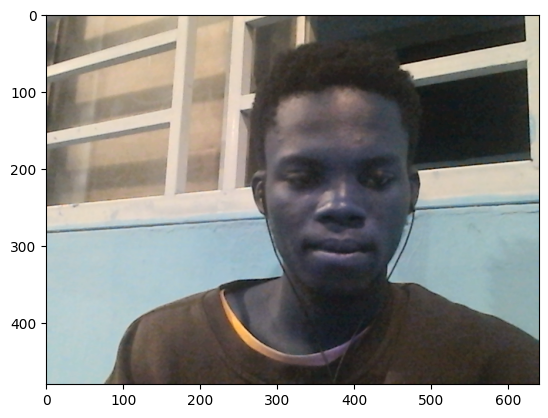

In [37]:
woker_cls.sign_out(database)

In [38]:
database['godwin']

array([[-0.04097715, -0.01436631, -0.10901113, -0.13435322,  0.02198865,
        -0.03572067,  0.02246642, -0.00877015,  0.01853243, -0.0832531 ,
         0.1201079 ,  0.03308384, -0.09225164, -0.18950139, -0.03455999,
        -0.01595302,  0.01191015, -0.08019225,  0.06283563, -0.16051695,
        -0.00421842,  0.02479291, -0.07766005, -0.07134196,  0.00392015,
        -0.09729471,  0.11176402,  0.01199224, -0.06028102,  0.01036124,
        -0.1397091 ,  0.00069698, -0.01029233,  0.07878727,  0.10825481,
        -0.00769239,  0.09133875, -0.08909252,  0.06357151, -0.1133888 ,
        -0.01179298,  0.08477595, -0.05169899,  0.0570813 , -0.0799913 ,
        -0.15979695,  0.04425357, -0.10522493,  0.03245587,  0.04847395,
        -0.16204356, -0.02068233,  0.11312284, -0.06716172, -0.06193649,
         0.09853072,  0.03938486,  0.04426705, -0.0818246 , -0.15154284,
        -0.12301826,  0.00604264, -0.05577276,  0.0866964 ,  0.06145559,
         0.20372596, -0.00928178,  0.07715554, -0.0